In [66]:
#Importing Necessary Libarires
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import warnings


### Dataset Extraction and Exploration

In [67]:
# Reading the Dataset
HCHO_data = pd.read_csv('Cleaned_HCHO_Data.csv')

# Basic Info
HCHO_data.info()
HCHO_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12430 entries, 0 to 12429
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HCHO Reading  12430 non-null  float64
 1   Location      12430 non-null  object 
 2   Current Date  12430 non-null  object 
 3   Next Date     12430 non-null  object 
dtypes: float64(1), object(3)
memory usage: 388.6+ KB


,HCHO Reading,Location,Current Date,Next Date
0,0.000197,Colombo Proper,2019-01-01,2019-01-02
1,0.000263,Colombo Proper,2019-01-02,2019-01-03
2,0.000099,Colombo Proper,2019-01-03,2019-01-04
3,0.000210,Colombo Proper,2019-01-04,2019-01-05
4,0.000179,Colombo Proper,2019-01-05,2019-01-06


(12430, 4)

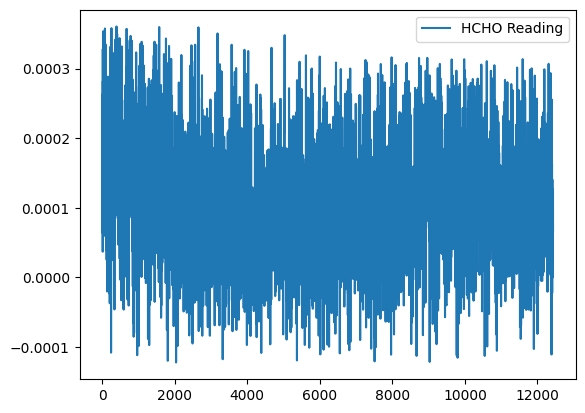

In [68]:
# Plotting the basic data
HCHO_data.plot()

# Dataframe Shape
HCHO_data.shape

## Staionary of the Time Series

Stationarity refers to a situation where the statistical properties like the mean, variance, and autocorrelation—are constant over time. This property is important because many statistical methods and models for time series analysis require the data to be stationary in order to continue with modelling and interpriting the results.

In [69]:
# Convert 'Current Date' to datetime type
HCHO_data['Current Date'] = pd.to_datetime(HCHO_data['Current Date'])

# Set 'Current Date' as the index of the DataFrame
HCHO_data.set_index('Current Date', inplace=True)

### Time-Series Plot (All Cities)

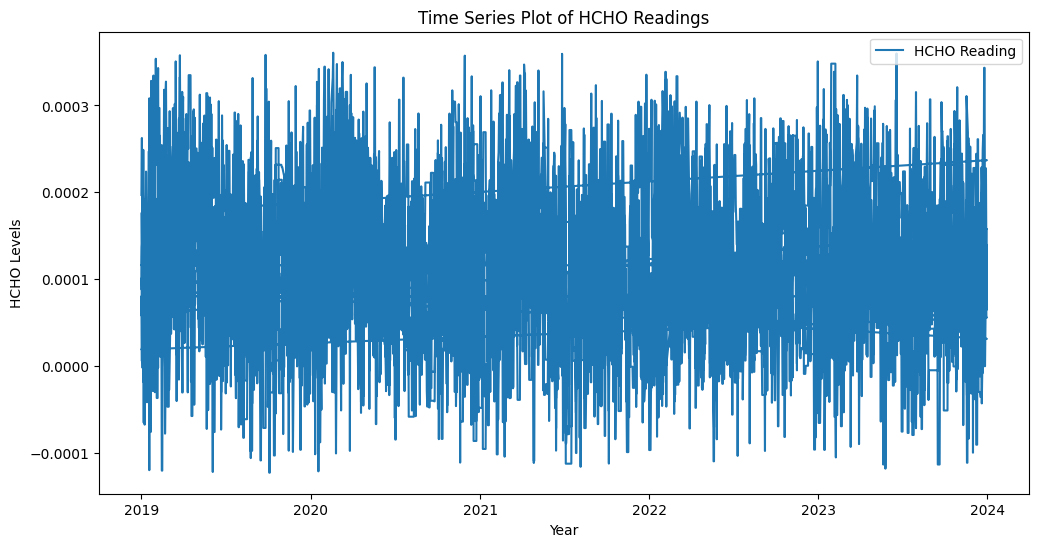

In [70]:
# Plotting Time Series Plot
plt.figure(figsize=(12, 6))
plt.plot(HCHO_data['HCHO Reading'], label='HCHO Reading')
plt.title('Time Series Plot of HCHO Readings')
plt.xlabel('Year')
plt.ylabel('HCHO Levels')
plt.legend()
plt.show()

Based on this plot we can see the data points are over the time is staionary Let's consider fewer other plots to see the stationary of the dataset.

#### ACF Plot (Auto Correlation Function) (All Cities)

<Figure size 1200x600 with 0 Axes>

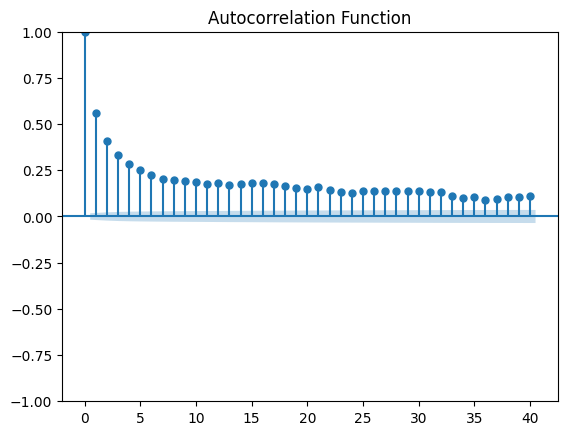

In [71]:
# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(HCHO_data['HCHO Reading'], lags=40, alpha=0.05)
plt.title('Autocorrelation Function')
plt.show()

### PACF Plot (Partial-Auto Correlation Function) (All Cities)

<Figure size 1200x600 with 0 Axes>

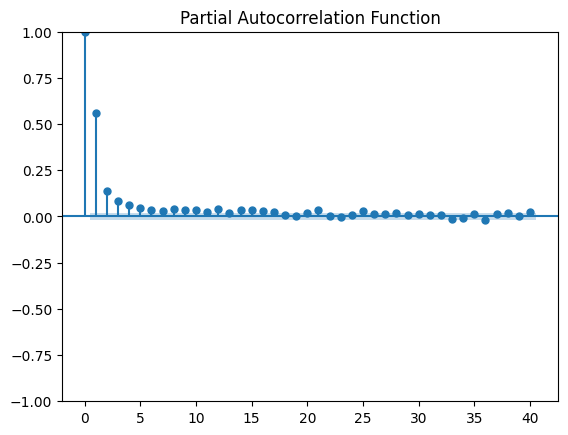

In [72]:
# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(HCHO_data['HCHO Reading'], lags=40, alpha=0.05)
plt.title('Partial Autocorrelation Function')
plt.show()

### Rolling Statictics Plot

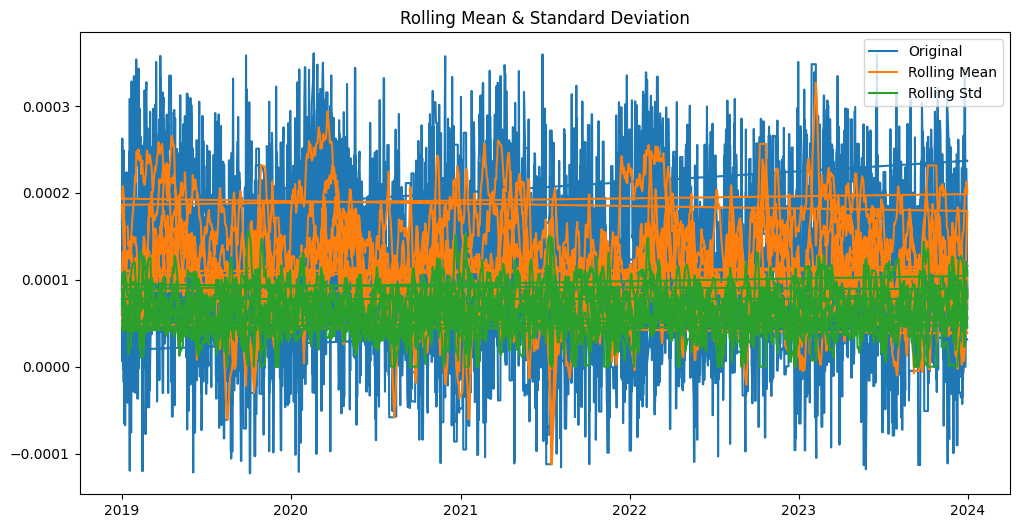

In [73]:
# Rolling Statistics Plot
rolling_mean = HCHO_data['HCHO Reading'].rolling(window=12).mean()
rolling_std = HCHO_data['HCHO Reading'].rolling(window=12).std()

plt.figure(figsize=(12, 6))
plt.plot(HCHO_data['HCHO Reading'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

In [74]:
# Augmented Dickey-Fuller Test
adf_result = adfuller(HCHO_data['HCHO Reading'])

# Extract and print ADF statistic and p-value
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

# Check if the p-value is less than the significance level
if adf_result[1] < 0.05:
    print("The time series is likely stationary (Reject null hypothesis)")
else:
    print("The time series is likely non-stationary (Fail to reject null hypothesis)")

ADF Statistic: -11.434209229491477
p-value: 6.406701833763946e-21
The time series is likely stationary (Reject null hypothesis)


#### Stationary Checks for Each Location

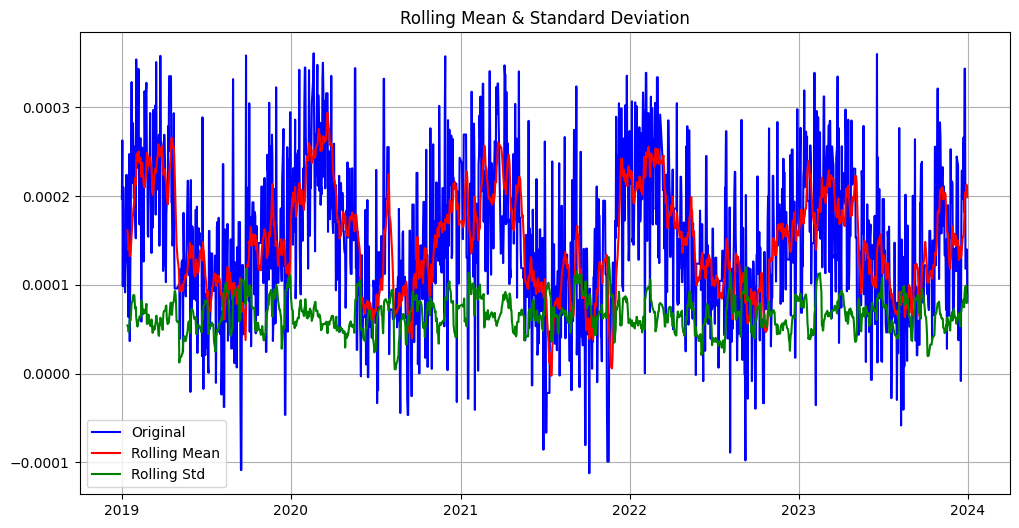

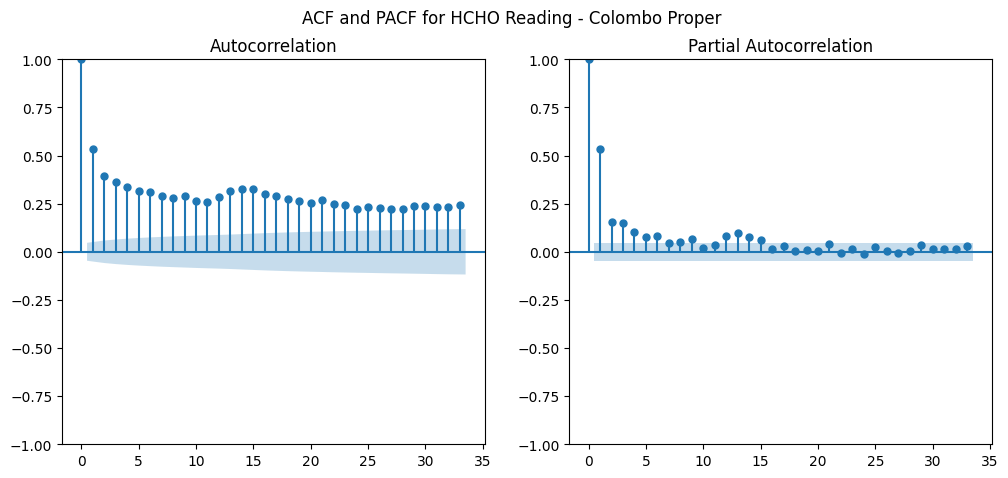

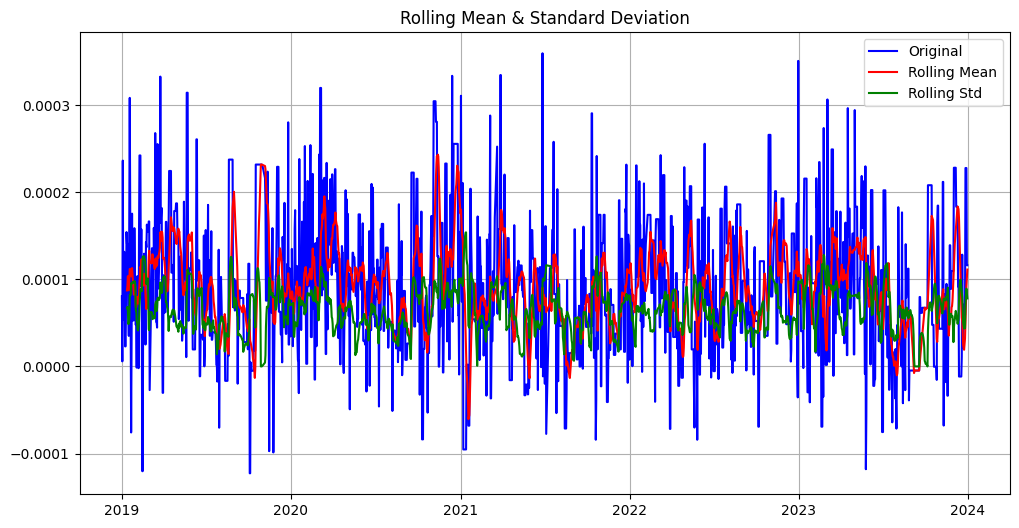

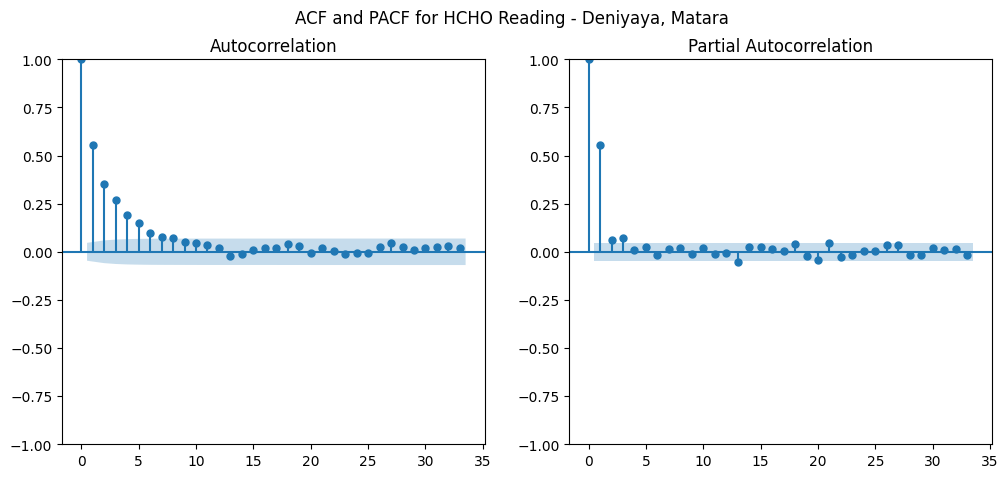

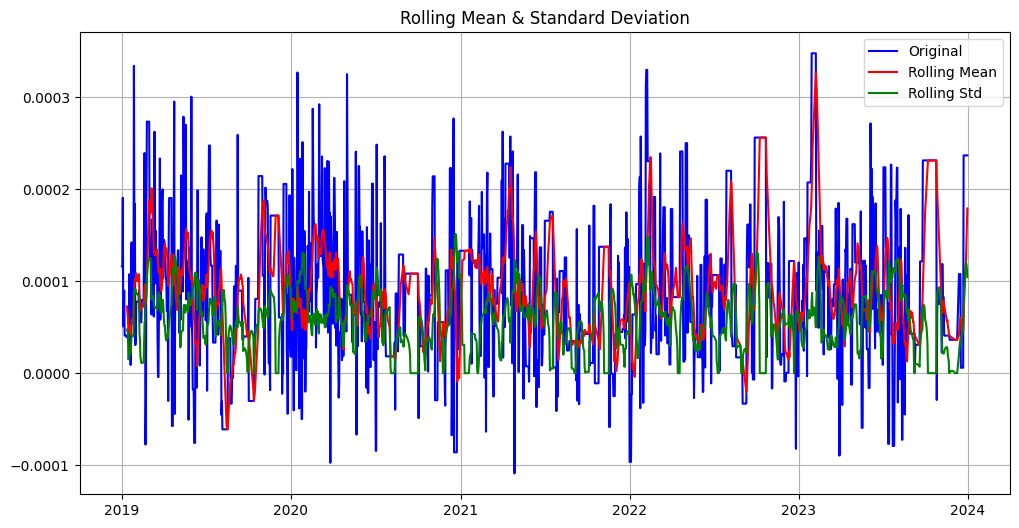

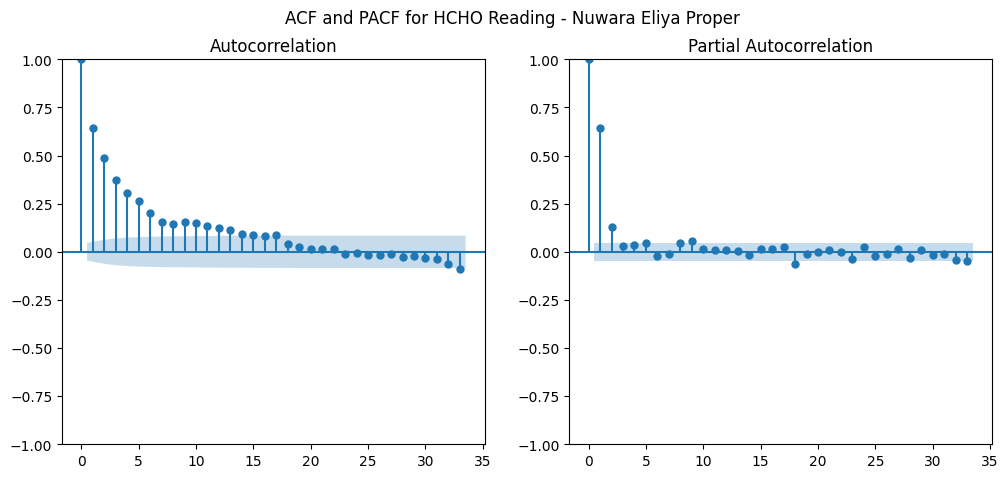

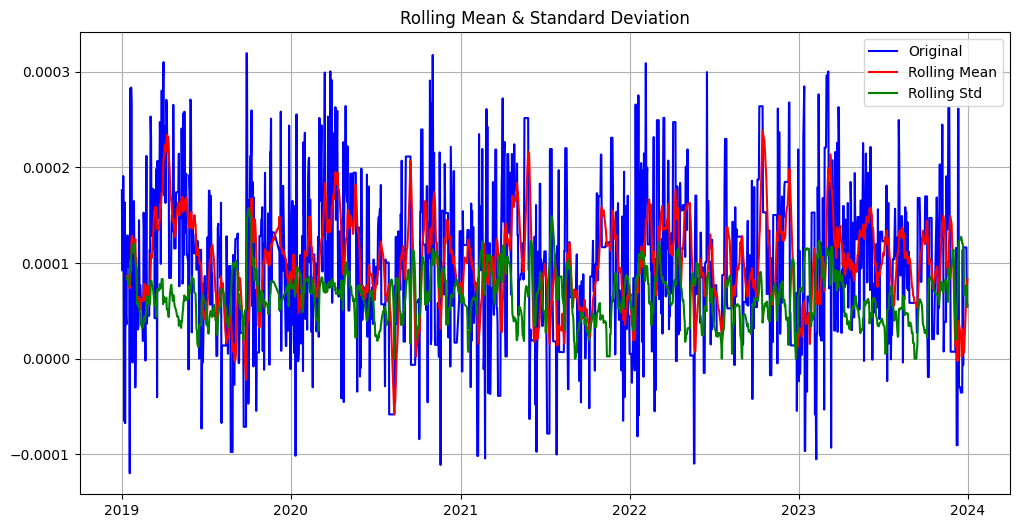

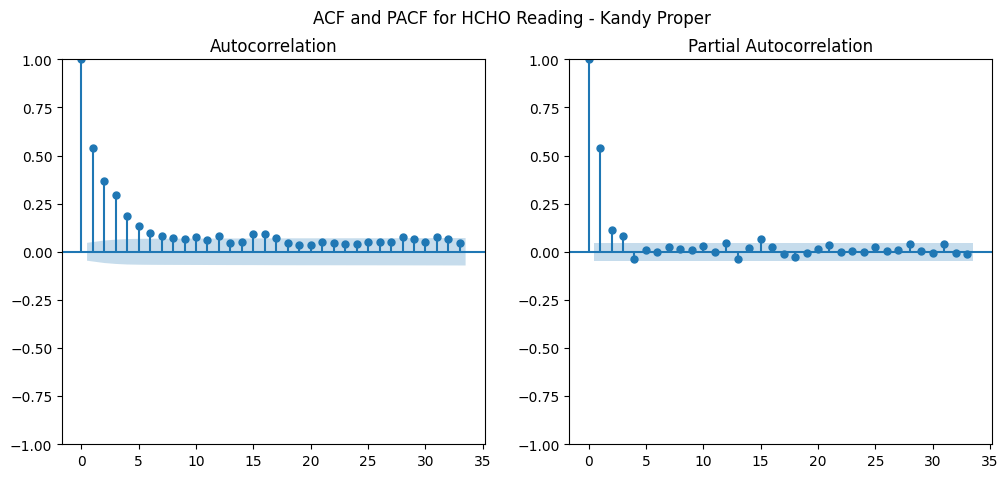

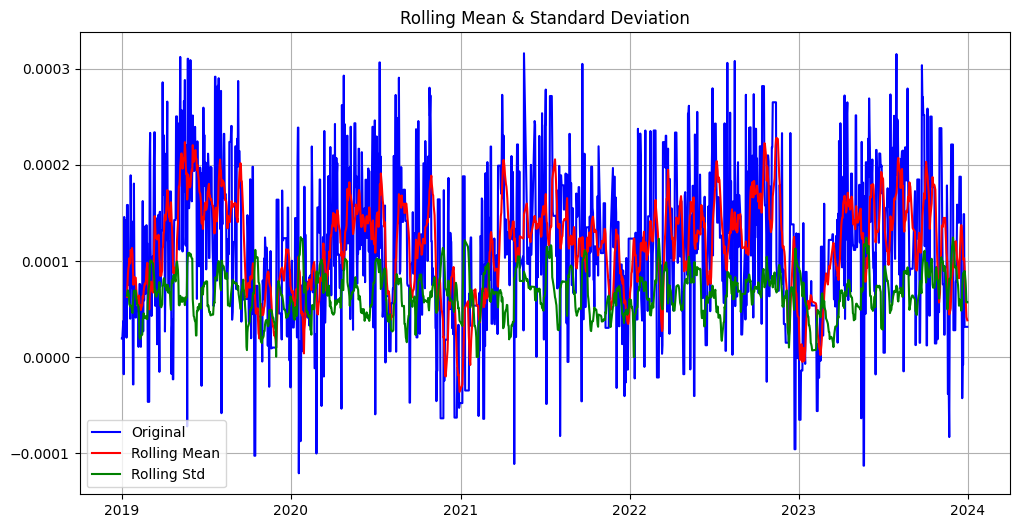

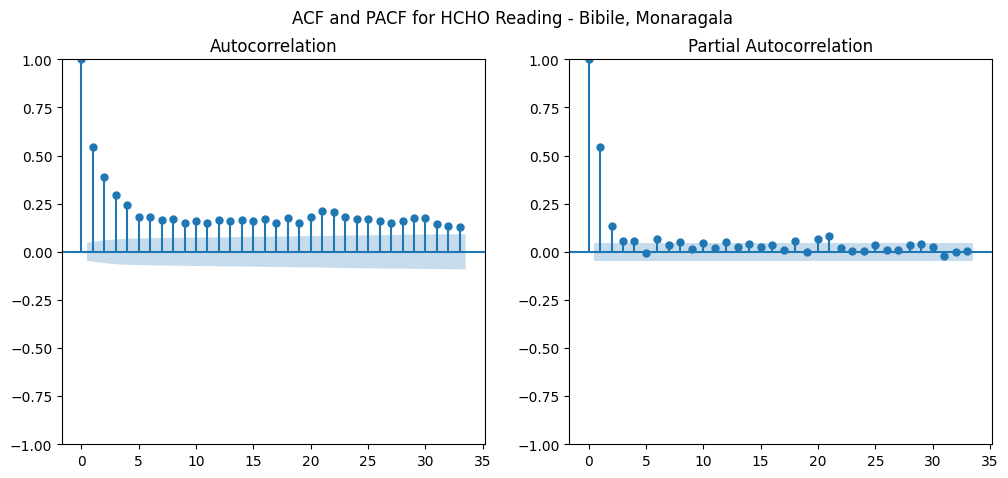

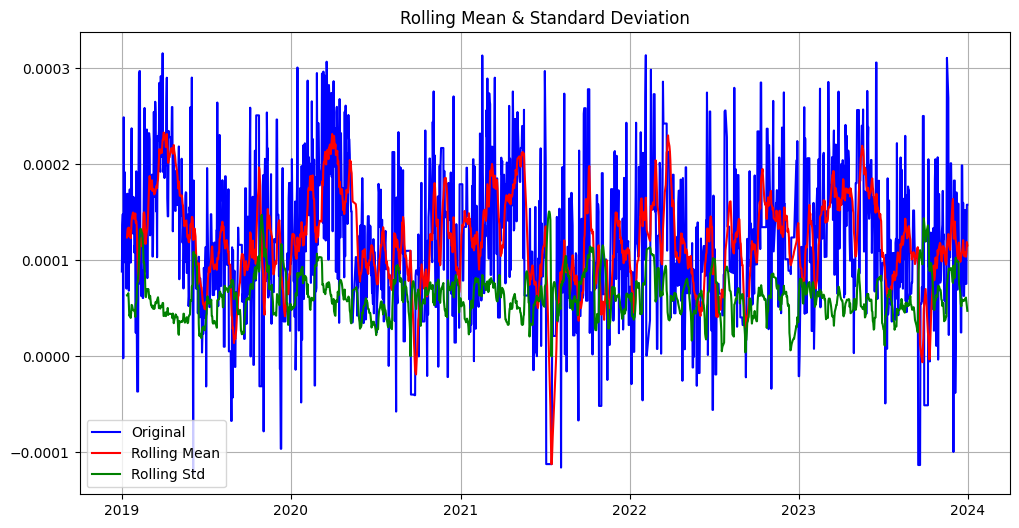

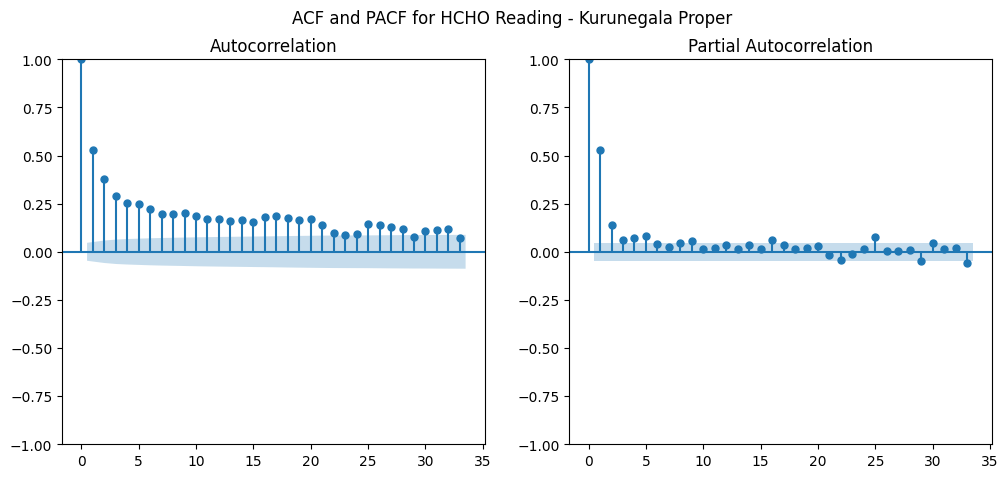

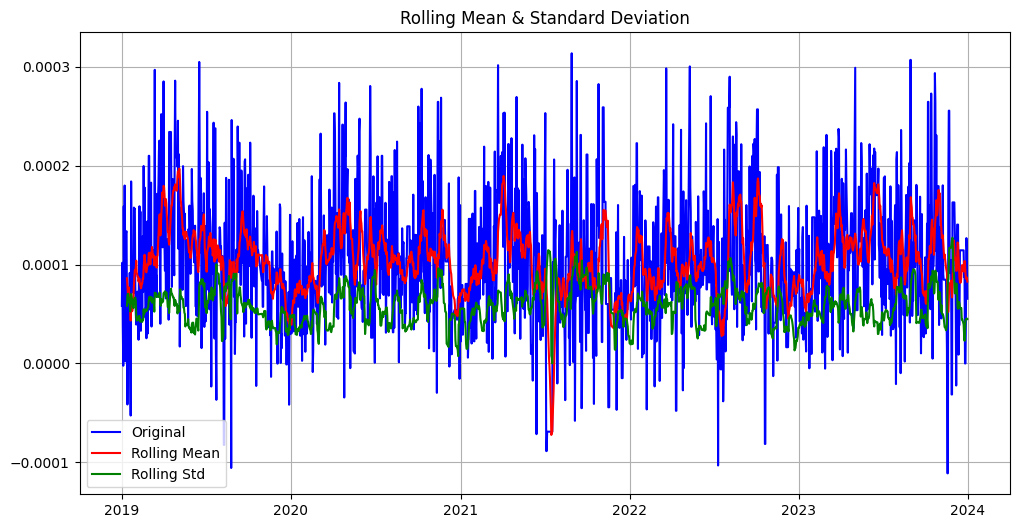

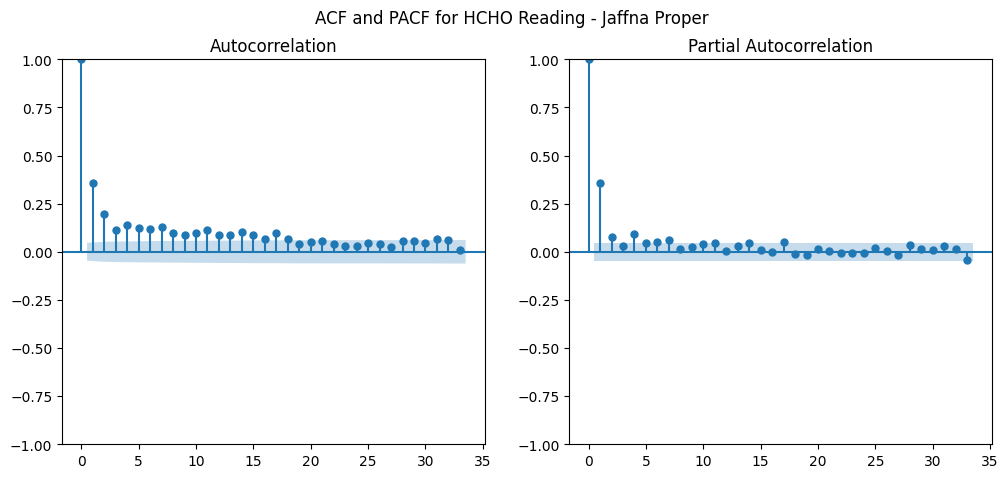

In [75]:
# Check for stationarity
def test_stationarity(timeseries):
    # Calculate rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # Plot rolling statistics
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='green', label='Rolling Std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.grid(True)
    plt.show()
    

# Get unique cities in the dataset
cities = HCHO_data['Location'].unique()

# Loop over each city
for city in cities:
    city_data = HCHO_data[HCHO_data['Location'] == city]

    # Check for stationarity for the current city
    test_stationarity(city_data['HCHO Reading'])
    # Plot ACF and PACF for the current city
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    plot_acf(city_data['HCHO Reading'], ax=ax[0])
    plot_pacf(city_data['HCHO Reading'], ax=ax[1])
    plt.suptitle(f'ACF and PACF for HCHO Reading - {city}')
    plt.show()

From These plots and results interpret that this dataframe is likely stationary. Therefore we can reject the null hypothesis and prove that this dataframe is good to fit with any time series Model.

## Model Comparison

### ARIMA

In [76]:
# Filter data for 'Colombo Proper'
colombo_data_compare = HCHO_data[HCHO_data['Location'] == 'Colombo Proper']
colombo_data_compare = colombo_data_compare.sort_index().asfreq('D')  # 'D' for daily frequency


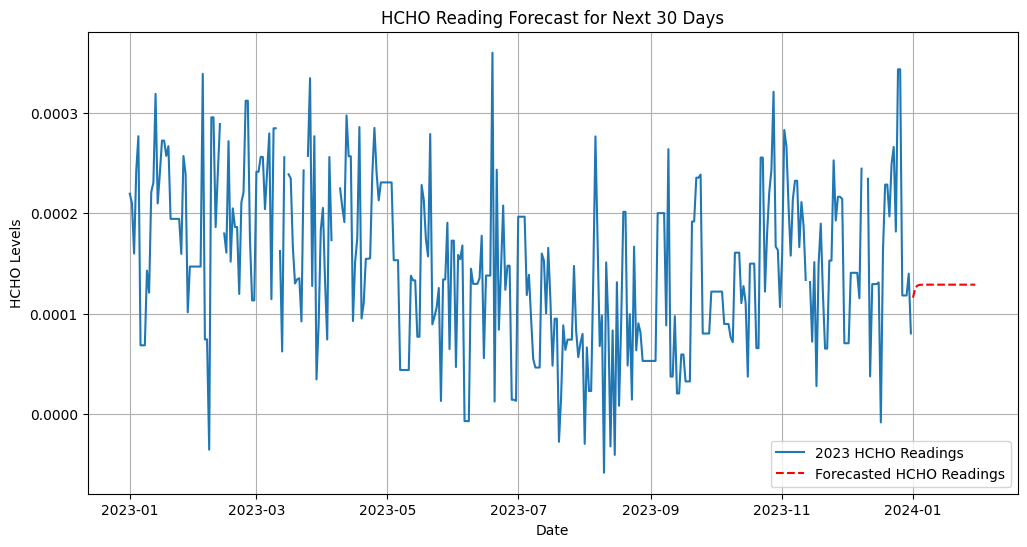

In [77]:
model = ARIMA(colombo_data_compare['HCHO Reading'], order=(1,1,1))
fitted_model = model.fit()

forecast = fitted_model.get_forecast(steps=30)
forecast_index = pd.date_range(start=colombo_data_compare.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
predicted_means = forecast.predicted_mean
predicted_cis = forecast.conf_int()

# Filtering the data for 2023 for plotting
colombo_data_2023 = colombo_data_compare[colombo_data_compare.index.year == 2023]

plt.figure(figsize=(12, 6))
plt.plot(colombo_data_2023.index, colombo_data_2023['HCHO Reading'], label='2023 HCHO Readings')
plt.plot(forecast_index, predicted_means, color='red', label='Forecasted HCHO Readings', linestyle='--')
plt.title('HCHO Reading Forecast for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('HCHO Levels')
plt.legend()
plt.grid(True)
plt.show()


### SARIMA

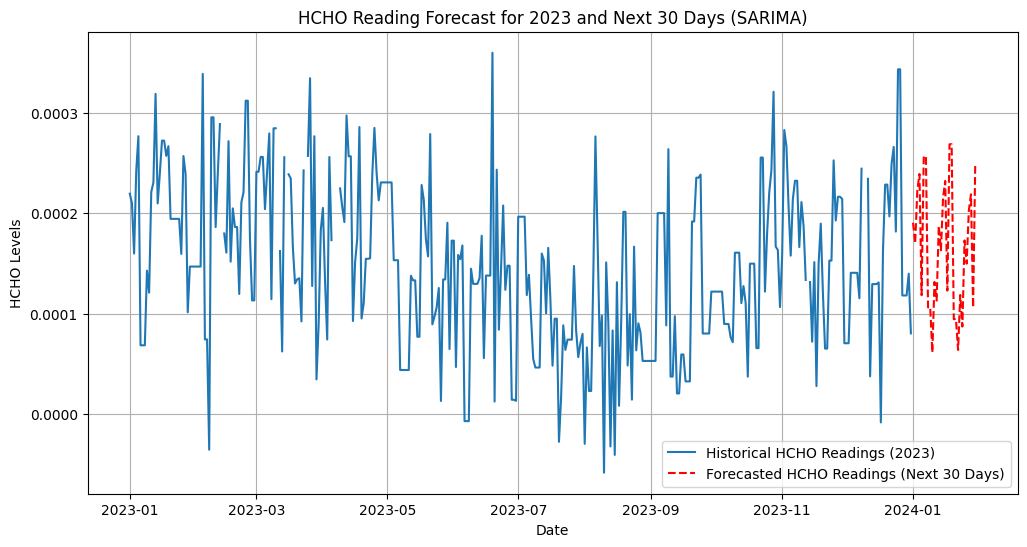

In [78]:
sarima_model = SARIMAX(colombo_data_compare['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

forecast_30days = sarima_result.forecast(steps=30)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(colombo_data_2023.index, colombo_data_2023['HCHO Reading'], label='Historical HCHO Readings (2023)')
plt.plot(forecast_30days.index, forecast_30days, color='red', label='Forecasted HCHO Readings (Next 30 Days)', linestyle='--')
plt.title('HCHO Reading Forecast for 2023 and Next 30 Days (SARIMA)')
plt.xlabel('Date')
plt.ylabel('HCHO Levels')
plt.legend()
plt.grid(True)
plt.show()

### SARIMA with external features

In [79]:
# External Weather Features
weather_data = pd.read_csv('Datasets\\External Data\\pre_proecessed_weather_data.csv')

weather_data.head()


,year,month,day,weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,shortwave_radiation_sum,rain_sum,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,latitude,longitude,city
0,2010,1,1,2,30.0,22.7,26.1,34.4,25.2,29.2,20.92,0.0,11.7,27.4,20,7.0,79.899994,Colombo
1,2010,1,2,51,29.9,23.5,26.2,33.8,26.2,29.8,17.71,0.1,13.0,27.0,24,7.0,79.899994,Colombo
2,2010,1,3,51,29.5,23.2,26.0,34.3,26.3,29.9,17.76,0.6,12.3,27.4,16,7.0,79.899994,Colombo
3,2010,1,4,2,28.9,21.9,25.3,31.6,23.4,27.8,16.50,0.0,17.0,34.6,356,7.0,79.899994,Colombo
4,2010,1,5,1,28.1,21.3,24.5,30.1,23.1,26.1,23.61,0.0,18.7,37.1,355,7.0,79.899994,Colombo


In [80]:
from sklearn.model_selection import train_test_split


external_data = weather_data[(weather_data['year'].isin([2019,2020,2021,2022])) & (weather_data['city'] == 'Colombo')][['year', 'month', 'day', 'weathercode', 'temperature_2m_max', 'temperature_2m_min','temperature_2m_mean','apparent_temperature_max','apparent_temperature_min','apparent_temperature_mean','rain_sum','windspeed_10m_max']]

#set index to datetime in external data
external_data['Date'] = pd.to_datetime(external_data[['year', 'month', 'day']])

# Set 'Date' column as the index
external_data.set_index('Date', inplace=True)
external_data.drop(columns=['year', 'month', 'day'], inplace=True)

external_data.head()

# Joinning the data with HCHO data
colombo_data_compare_with_external = colombo_data_compare.join(external_data, how='inner')
colombo_data_compare_with_external.drop(index='2022-12-31')

# Splitting the data
train_data, test_data = train_test_split(colombo_data_compare_with_external[colombo_data_compare_with_external['Location'] == 'Colombo Proper'], test_size=0.2, shuffle=False)

# Define external variables
external_variables = ['weathercode', 'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'apparent_temperature_max', 'apparent_temperature_min', 'apparent_temperature_mean', 'rain_sum', 'windspeed_10m_max']

# Fit SARIMAX model
sarimax_model = SARIMAX(train_data['HCHO Reading'], exog=train_data[external_variables], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_result = sarimax_model.fit()

# Forecast using SARIMAX model
forecast = sarimax_result.forecast(steps=len(test_data), exog=test_data[external_variables])

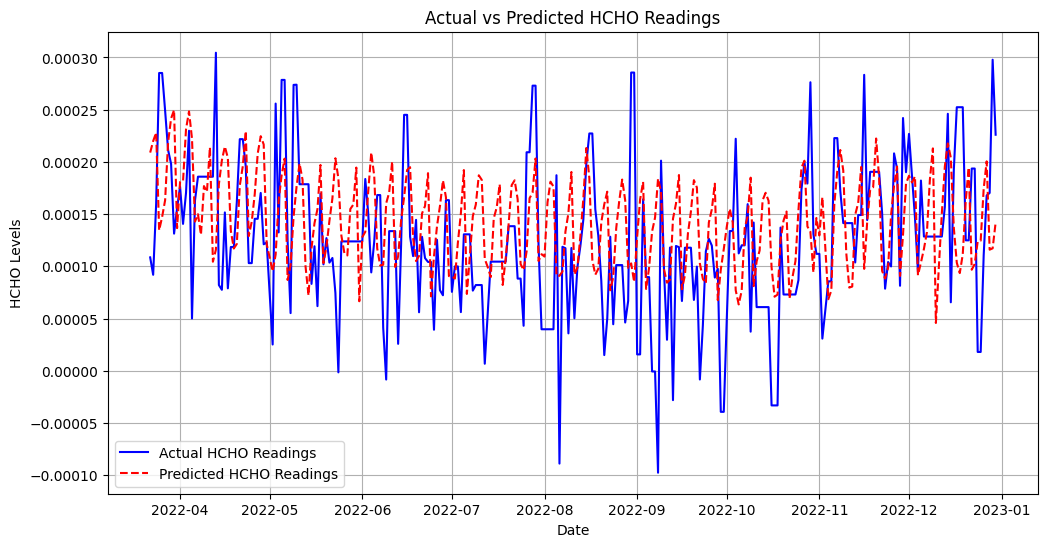

In [81]:
# Plotting actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['HCHO Reading'], label='Actual HCHO Readings', color='blue')
plt.plot(test_data.index, forecast, label='Predicted HCHO Readings', color='red', linestyle='--')
plt.title('Actual vs Predicted HCHO Readings')
plt.xlabel('Date')
plt.ylabel('HCHO Levels')
plt.legend()
plt.grid(True)
plt.show()

Well based on these results the SARIMAX with external features shows a good prediction with expected value and the actual value but the thing is if we need to predict the next days we need the features of thhose days. therefore using this it quite the impossible to do the predictions.

In Comparison , we can see that how values varies in  SARIMA, ARIMA and  SARIMAX. But when interpriting these results the SARIMA displays the best possible outcome dropping SARIMAX because of that need of future external features. Therefore let's continue with SARIMA Model.

## SARIMA Model Fitting

### Colombo Proper

#### Data Splitting

In [82]:
#Splitting the dataset into train and test sets
split_ratio = 0.8 # 80% of data to train

colombo_data = HCHO_data[HCHO_data['Location'] == 'Colombo Proper']
train_size = int(len(colombo_data) * split_ratio)
train_data_colombo, test_data_colombo = colombo_data[0:train_size], colombo_data[train_size:]

print("Full Data Size:-", colombo_data.shape)
print("Train Data Size :-", train_data_colombo.shape)
print("Test Data Size :-", test_data_colombo.shape)

Full Data Size:- (1766, 3)
Train Data Size :- (1412, 3)
Test Data Size :- (354, 3)


#### Model Training and Evaluation

In [83]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Fitting the SARIMA Model
# Fit SARIMA model to the training data
sarima_model = SARIMAX(train_data_colombo['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

# Generate forecasts for the test set
test_forecast = sarima_result.forecast(steps=len(test_data_colombo))

# Calculate evaluation metrics
mse = mean_squared_error(test_data_colombo['HCHO Reading'], test_forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_colombo['HCHO Reading'], test_forecast)

# Print evaluation metrics
print("\nEvaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")



Evaluation Metrics:
Mean Squared Error (MSE): 1.2436663752562711e-07
Root Mean Squared Error (RMSE): 0.0003526565432905323
Mean Absolute Error (MAE): 0.0003058374921713632


#### Predicting HCHO Levels of Next 30 Days

In [84]:
# Generate forecasts for the next 10 days by fitting entire dataset for the model
sarima_model = SARIMAX(colombo_data['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

forecast_30days = sarima_result.forecast(steps=31)

# Print the forecasted values
print("\nForecasted HCHO levels for the next 30 days:")
print(forecast_30days)


Forecasted HCHO levels for the next 30 days:
1766    0.000145
1767    0.000157
1768    0.000223
1769    0.000231
1770    0.000133
1771    0.000211
1772    0.000194
1773    0.000129
1774    0.000125
1775    0.000076
1776    0.000151
1777    0.000164
1778    0.000183
1779    0.000174
1780    0.000234
1781    0.000243
1782    0.000149
1783    0.000249
1784    0.000237
1785    0.000128
1786    0.000125
1787    0.000090
1788    0.000149
1789    0.000143
1790    0.000174
1791    0.000171
1792    0.000233
1793    0.000242
1794    0.000146
1795    0.000240
1796    0.000227
Name: predicted_mean, dtype: float64


#### Plotting Results

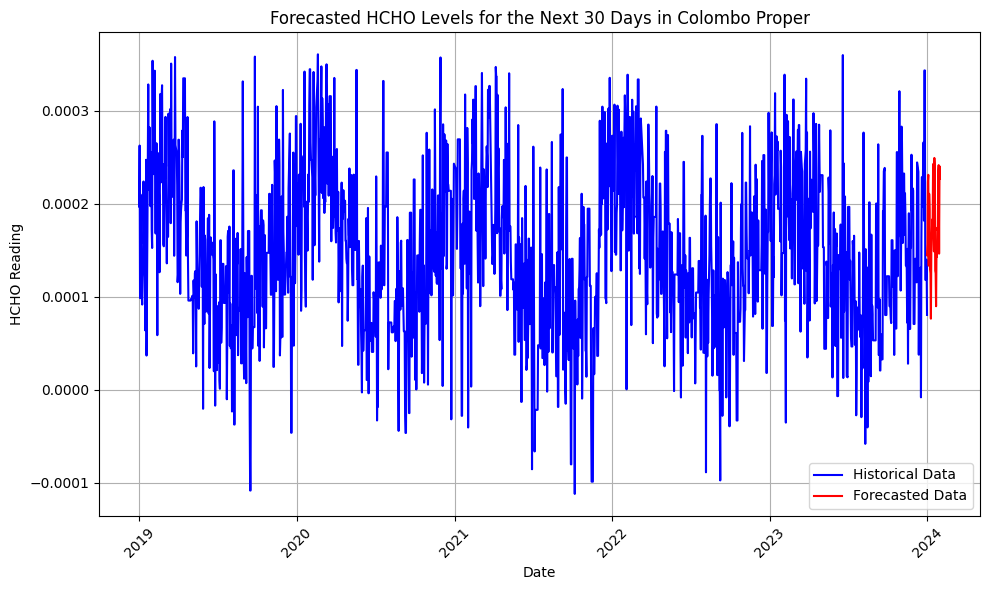

In [85]:
# Plot historical data
plt.figure(figsize=(10, 6))
plt.plot(colombo_data.index, colombo_data['HCHO Reading'], label='Historical Data', color='blue')

# Plot forecasted values for the next 10 days
forecast_dates = pd.date_range(start=colombo_data.index[-1], periods=31)
plt.plot(forecast_dates, forecast_30days, label='Forecasted Data', color='red')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('Forecasted HCHO Levels for the Next 30 Days in Colombo Proper')
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()


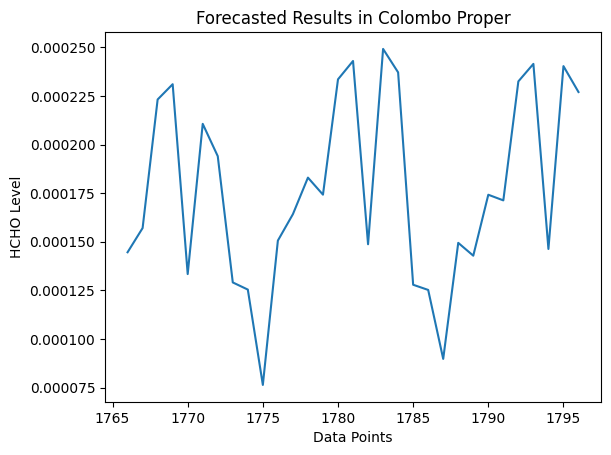

In [86]:
# Forecasted Results
plt.title("Forecasted Results in Colombo Proper")
plt.xlabel('Data Points')
plt.ylabel('HCHO Level')
plt.plot(forecast_30days)

### Jaffna Proper

#### Data Splitting

In [87]:
#Splitting the dataset into train and test sets
split_ratio = 0.8 

jaffna_data = HCHO_data[HCHO_data['Location'] == 'Jaffna Proper']
train_size = int(len(jaffna_data) * split_ratio)
train_data_jaffna, test_data_jaffna = jaffna_data[0:train_size], jaffna_data[train_size:]

print("Full Data Size:-", jaffna_data.shape)
print("Train Data Size :-", train_data_jaffna.shape)
print("Test Data Size :-", test_data_jaffna.shape)


Full Data Size:- (1785, 3)
Train Data Size :- (1428, 3)
Test Data Size :- (357, 3)


#### Model Training and Prediction

In [88]:
# Fitting the SARIMA Model
# Fit SARIMA model to the training data
sarima_model = SARIMAX(train_data_jaffna['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

# Generate forecasts for the test set
test_forecast = sarima_result.forecast(steps=len(test_data_jaffna))

# Calculate evaluation metrics
mse = mean_squared_error(test_data_jaffna['HCHO Reading'], test_forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_jaffna['HCHO Reading'], test_forecast)

# Print evaluation metrics
print("\nEvaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")



Evaluation Metrics:
Mean Squared Error (MSE): 1.1228447623489302e-07
Root Mean Squared Error (RMSE): 0.0003350887587414609
Mean Absolute Error (MAE): 0.0002850046771371725


#### Forecasting next 30 days

In [89]:
# Generate forecasts for the next 10 days by fitting entire dataset for the model
sarima_model = SARIMAX(jaffna_data['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

forecast_30days = sarima_result.forecast(steps=31)

# Print the forecasted values
print("\nForecasted HCHO levels for the next 30 days:")
print(forecast_30days)


Forecasted HCHO levels for the next 30 days:
1785    0.000101
1786    0.000089
1787    0.000085
1788    0.000112
1789    0.000045
1790    0.000057
1791    0.000056
1792    0.000088
1793    0.000095
1794    0.000099
1795    0.000088
1796    0.000061
1797    0.000095
1798    0.000089
1799    0.000086
1800    0.000105
1801    0.000050
1802    0.000059
1803    0.000032
1804    0.000054
1805    0.000075
1806    0.000100
1807    0.000089
1808    0.000055
1809    0.000089
1810    0.000081
1811    0.000078
1812    0.000100
1813    0.000041
1814    0.000051
1815    0.000031
Name: predicted_mean, dtype: float64


#### Data Plotting Results

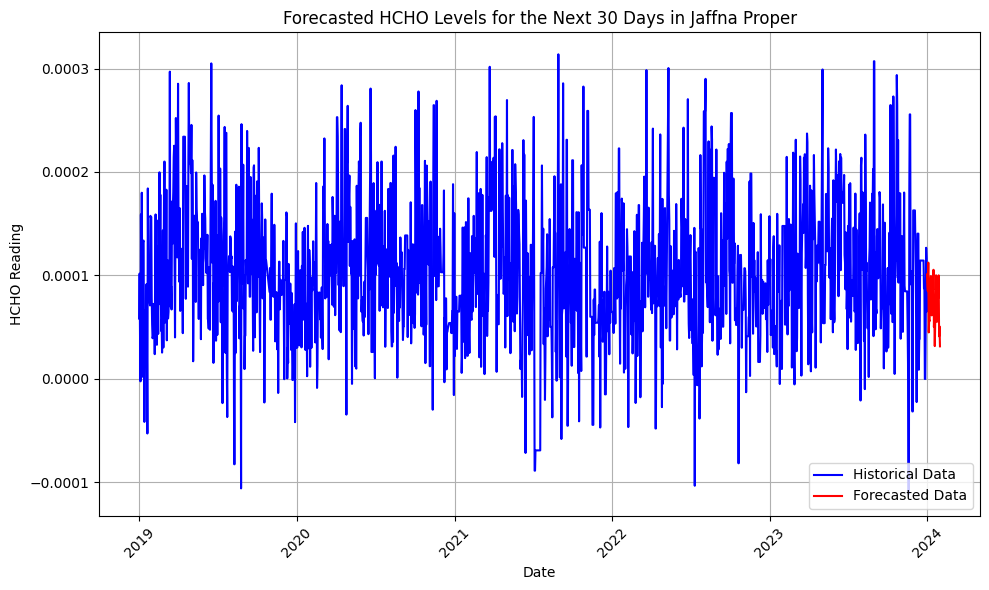

In [90]:
# Plot historical data
plt.figure(figsize=(10, 6))
plt.plot(jaffna_data.index, jaffna_data['HCHO Reading'], label='Historical Data', color='blue')

# Plot forecasted values for the next 10 days
forecast_dates = pd.date_range(start=jaffna_data.index[-1], periods=31)
plt.plot(forecast_dates, forecast_30days, label='Forecasted Data', color='red')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('Forecasted HCHO Levels for the Next 30 Days in Jaffna Proper')
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()


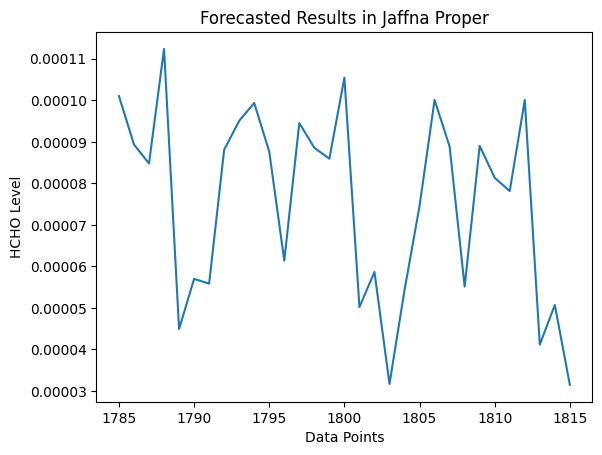

In [91]:
# Forecasted Results
plt.title("Forecasted Results in Jaffna Proper")
plt.xlabel('Data Points')
plt.ylabel('HCHO Level')
plt.plot(forecast_30days)

### Deniyaya, Matara

#### Data Splitting

In [92]:
#Splitting the dataset into train and test sets
split_ratio = 0.8 

matara_data = HCHO_data[HCHO_data['Location'] == 'Deniyaya, Matara']
train_size = int(len(matara_data) * split_ratio)
train_data_matara, test_data_matara = matara_data[0:train_size], matara_data[train_size:]

print("Full Data Size:-", matara_data.shape)
print("Train Data Size :-", train_data_matara.shape)
print("Test Data Size :-", test_data_matara.shape)

Full Data Size:- (1777, 3)
Train Data Size :- (1421, 3)
Test Data Size :- (356, 3)


#### Model Trainining and Prediction

In [93]:
# Fitting the SARIMA Model
# Fit SARIMA model to the training data
sarima_model = SARIMAX(train_data_matara['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

# Generate forecasts for the test set
test_forecast = sarima_result.forecast(steps=len(test_data_matara))

# Calculate evaluation metrics
mse = mean_squared_error(test_data_matara['HCHO Reading'], test_forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_matara['HCHO Reading'], test_forecast)

# Print evaluation metrics
print("\nEvaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")



Evaluation Metrics:
Mean Squared Error (MSE): 1.0249583117857301e-08
Root Mean Squared Error (RMSE): 0.00010124022480149529
Mean Absolute Error (MAE): 7.970321204103042e-05


#### Forecasting next 30 days

In [94]:
# Generate forecasts for the next 10 days by fitting entire dataset for the model
sarima_model = SARIMAX(matara_data['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

forecast_30days = sarima_result.forecast(steps=31)

# Print the forecasted values
print("\nForecasted HCHO levels for the next 30 days:")
print(forecast_30days)


Forecasted HCHO levels for the next 30 days:
1777    0.000156
1778    0.000121
1779    0.000134
1780    0.000110
1781    0.000106
1782    0.000075
1783    0.000118
1784    0.000166
1785    0.000150
1786    0.000163
1787    0.000130
1788    0.000125
1789    0.000172
1790    0.000125
1791    0.000135
1792    0.000119
1793    0.000117
1794    0.000092
1795    0.000127
1796    0.000193
1797    0.000179
1798    0.000190
1799    0.000146
1800    0.000141
1801    0.000187
1802    0.000142
1803    0.000153
1804    0.000135
1805    0.000133
1806    0.000107
1807    0.000143
Name: predicted_mean, dtype: float64


#### Plotting Results

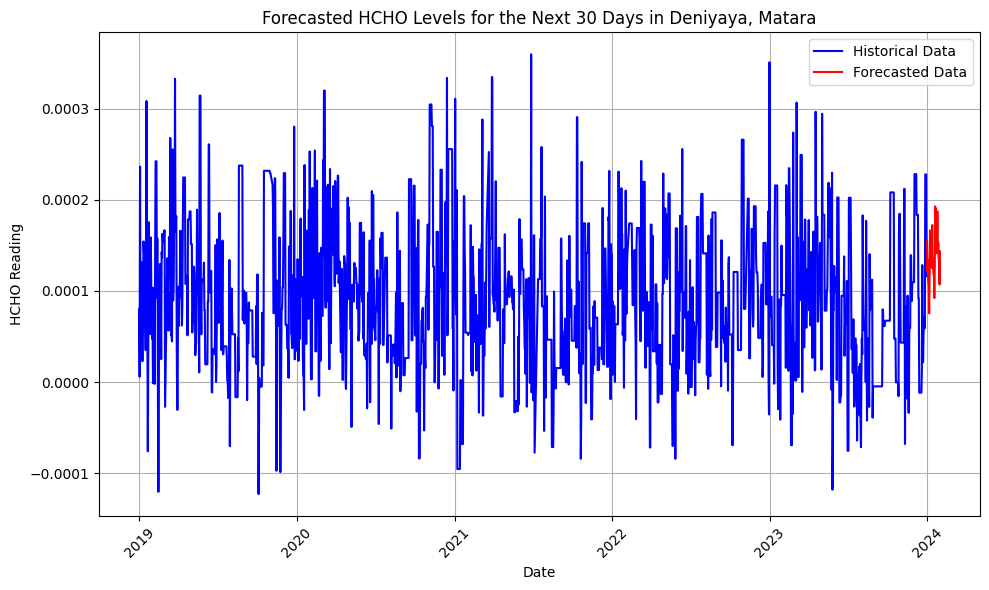

In [95]:
# Plot historical data
plt.figure(figsize=(10, 6))
plt.plot(matara_data.index, matara_data['HCHO Reading'], label='Historical Data', color='blue')

# Plot forecasted values for the next 10 days
forecast_dates = pd.date_range(start=matara_data.index[-1], periods=31)
plt.plot(forecast_dates, forecast_30days, label='Forecasted Data', color='red')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('Forecasted HCHO Levels for the Next 30 Days in Deniyaya, Matara')
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()


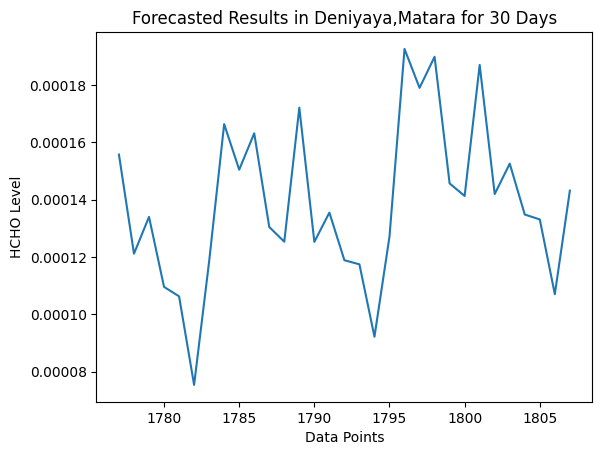

In [96]:
# Forecasted Results
plt.title("Forecasted Results in Deniyaya,Matara for 30 Days")
plt.xlabel('Data Points')
plt.ylabel('HCHO Level')
plt.plot(forecast_30days)

### Nuwara Eliya Proper

#### Data Splitting

In [97]:
#Splitting the dataset into train and test sets
split_ratio = 0.8 

nuwaraeliya_data = HCHO_data[HCHO_data['Location'] == 'Nuwara Eliya Proper']
train_size = int(len(nuwaraeliya_data) * split_ratio)
train_data_nuwaraeliya, test_data_nuwaraeliya = nuwaraeliya_data[0:train_size], nuwaraeliya_data[train_size:]

print("Full Data Size:-", nuwaraeliya_data.shape)
print("Train Data Size :-", train_data_nuwaraeliya.shape)
print("Test Data Size :-", test_data_nuwaraeliya.shape)

Full Data Size:- (1810, 3)
Train Data Size :- (1448, 3)
Test Data Size :- (362, 3)


#### Model Training and Prediction

In [98]:
# Fitting the SARIMA Model
# Fit SARIMA model to the training data
sarima_model = SARIMAX(train_data_nuwaraeliya['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

# Generate forecasts for the test set
test_forecast = sarima_result.forecast(steps=len(test_data_nuwaraeliya))

# Calculate evaluation metrics
mse = mean_squared_error(test_data_nuwaraeliya['HCHO Reading'], test_forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_nuwaraeliya['HCHO Reading'], test_forecast)

# Print evaluation metrics
print("\nEvaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")



Evaluation Metrics:
Mean Squared Error (MSE): 6.126377165568567e-07
Root Mean Squared Error (RMSE): 0.0007827117710606227
Mean Absolute Error (MAE): 0.0007023442015224193


#### Forecasting next 30 days

In [99]:
# Generate forecasts for the next 10 days by fitting entire dataset for the model
sarima_model = SARIMAX(nuwaraeliya_data['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

forecast_30days = sarima_result.forecast(steps=31)

# Print the forecasted values
print("\nForecasted HCHO levels for the next 30 days:")
print(forecast_30days)


Forecasted HCHO levels for the next 30 days:
1810    0.000228
1811    0.000226
1812    0.000230
1813    0.000290
1814    0.000291
1815    0.000315
1816    0.000315
1817    0.000313
1818    0.000309
1819    0.000277
1820    0.000278
1821    0.000278
1822    0.000273
1823    0.000272
1824    0.000276
1825    0.000367
1826    0.000368
1827    0.000387
1828    0.000387
1829    0.000386
1830    0.000383
1831    0.000356
1832    0.000357
1833    0.000357
1834    0.000351
1835    0.000350
1836    0.000354
1837    0.000440
1838    0.000441
1839    0.000461
1840    0.000461
Name: predicted_mean, dtype: float64


#### Plotting Results

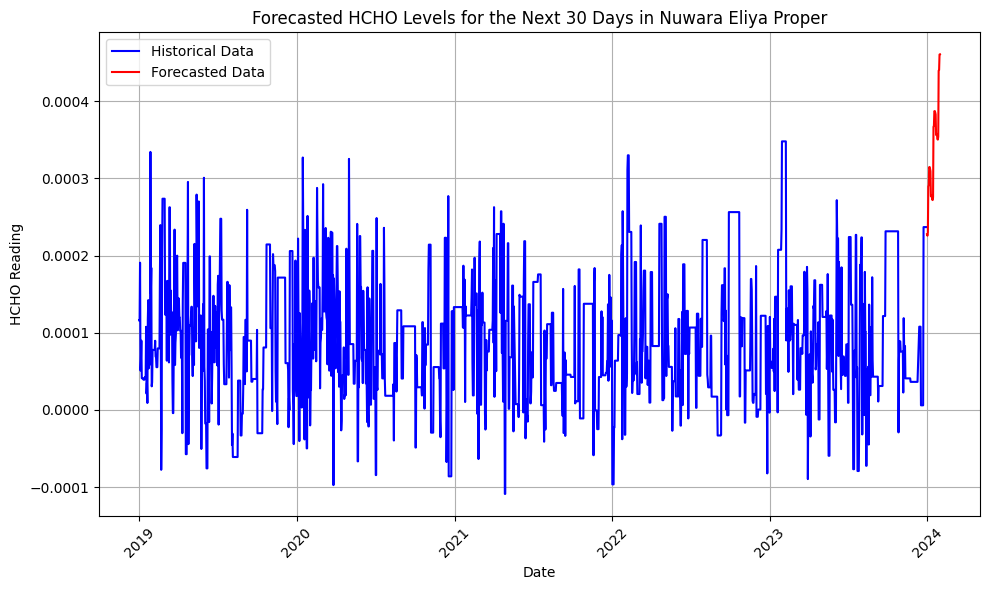

In [100]:
# Plot historical data
plt.figure(figsize=(10, 6))
plt.plot(nuwaraeliya_data.index, nuwaraeliya_data['HCHO Reading'], label='Historical Data', color='blue')

# Plot forecasted values for the next 10 days
forecast_dates = pd.date_range(start=nuwaraeliya_data.index[-1], periods=31)
plt.plot(forecast_dates, forecast_30days, label='Forecasted Data', color='red')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('Forecasted HCHO Levels for the Next 30 Days in Nuwara Eliya Proper')
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()


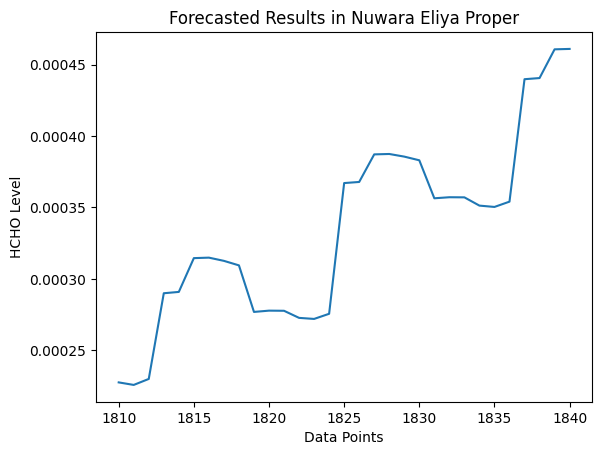

In [101]:
# Forecasted Results
plt.title("Forecasted Results in Nuwara Eliya Proper")
plt.xlabel('Data Points')
plt.ylabel('HCHO Level')
plt.plot(forecast_30days)

### Kandy proper

#### Data Splitting

In [102]:
#Splitting the dataset into train and test sets
split_ratio = 0.8 

kandy_data = HCHO_data[HCHO_data['Location'] == 'Kandy Proper']
train_size = int(len(kandy_data) * split_ratio)
train_data_kandy, test_data_kandy = kandy_data[0:train_size], kandy_data[train_size:]

print("Full Data Size:-", kandy_data.shape)
print("Train Data Size :-", train_data_kandy.shape)
print("Test Data Size :-", test_data_kandy.shape)

Full Data Size:- (1781, 3)
Train Data Size :- (1424, 3)
Test Data Size :- (357, 3)


#### Model Training and Evaluation

In [103]:
# Fitting the SARIMA Model
# Fit SARIMA model to the training data
sarima_model = SARIMAX(train_data_kandy['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

# Generate forecasts for the test set
test_forecast = sarima_result.forecast(steps=len(test_data_kandy))

# Calculate evaluation metrics
mse = mean_squared_error(test_data_kandy['HCHO Reading'], test_forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_kandy['HCHO Reading'], test_forecast)

# Print evaluation metrics
print("\nEvaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")



Evaluation Metrics:
Mean Squared Error (MSE): 4.4687561262645467e-07
Root Mean Squared Error (RMSE): 0.0006684875560744977
Mean Absolute Error (MAE): 0.0005969033994160204


#### Forecasting next 30 days

In [104]:
# Generate forecasts for the next 30 days by fitting entire dataset for the model
sarima_model = SARIMAX(kandy_data['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

forecast_30days = sarima_result.forecast(steps=31)

# Print the forecasted values
print("\nForecasted HCHO levels for the next 30 days:")
print(forecast_30days)


Forecasted HCHO levels for the next 30 days:
1781   -0.000002
1782    0.000047
1783    0.000024
1784    0.000176
1785    0.000171
1786    0.000082
1787    0.000090
1788    0.000087
1789    0.000083
1790    0.000071
1791    0.000064
1792    0.000062
1793    0.000008
1794    0.000073
1795    0.000033
1796    0.000179
1797    0.000176
1798    0.000103
1799    0.000108
1800    0.000106
1801    0.000103
1802    0.000093
1803    0.000077
1804    0.000075
1805    0.000020
1806    0.000083
1807    0.000045
1808    0.000193
1809    0.000189
1810    0.000113
1811    0.000119
Name: predicted_mean, dtype: float64


#### Plotting and Results

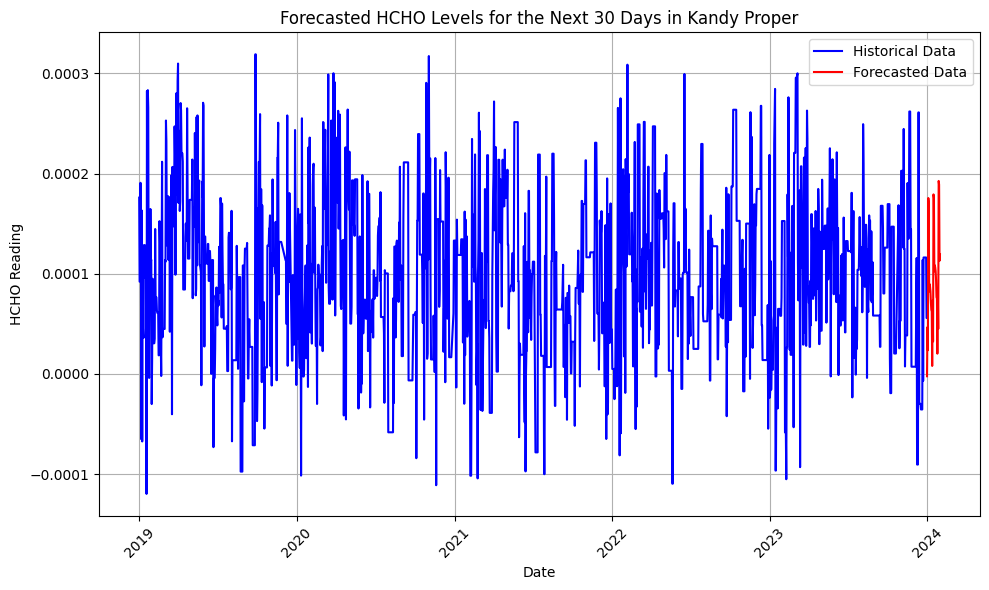

In [105]:
# Plot historical data
plt.figure(figsize=(10, 6))
plt.plot(kandy_data.index, kandy_data['HCHO Reading'], label='Historical Data', color='blue')

# Plot forecasted values for the next 10 days
forecast_dates = pd.date_range(start=kandy_data.index[-1], periods=31)
plt.plot(forecast_dates, forecast_30days, label='Forecasted Data', color='red')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('Forecasted HCHO Levels for the Next 30 Days in Kandy Proper')
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()


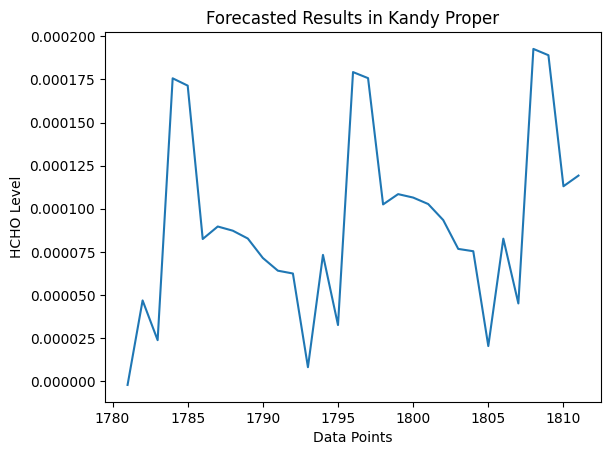

In [106]:
# Forecasted Results
plt.title("Forecasted Results in Kandy Proper")
plt.xlabel('Data Points')
plt.ylabel('HCHO Level')
plt.plot(forecast_30days)

### Kurunegala Proper

#### Splitting the Data

In [107]:
#Splitting the dataset into train and test sets
split_ratio = 0.8 

kurunegala_data = HCHO_data[HCHO_data['Location'] == 'Kurunegala Proper']
train_size = int(len(kurunegala_data) * split_ratio)
train_data_kurunegala, test_data_kurunegala = kurunegala_data[0:train_size], kurunegala_data[train_size:]

print("Full Data Size:-", kurunegala_data.shape)
print("Train Data Size :-", train_data_kurunegala.shape)
print("Test Data Size :-", test_data_kurunegala.shape)

Full Data Size:- (1764, 3)
Train Data Size :- (1411, 3)
Test Data Size :- (353, 3)


#### Model Training and Evaluation

In [108]:
# Fitting the SARIMA Model
# Fit SARIMA model to the training data
sarima_model = SARIMAX(train_data_kurunegala['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

# Generate forecasts for the test set
test_forecast = sarima_result.forecast(steps=len(test_data_kurunegala))

# Calculate evaluation metrics
mse = mean_squared_error(test_data_kurunegala['HCHO Reading'], test_forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_kurunegala['HCHO Reading'], test_forecast)

# Print evaluation metrics
print("\nEvaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")



Evaluation Metrics:
Mean Squared Error (MSE): 5.117386092678187e-07
Root Mean Squared Error (RMSE): 0.0007153590771548361
Mean Absolute Error (MAE): 0.0006402395737034386


#### Forecasting Next 30 Days

In [109]:
# Generate forecasts for the next 10 days by fitting entire dataset for the model
sarima_model = SARIMAX(kurunegala_data['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

forecast_30days = sarima_result.forecast(steps=31)

# Print the forecasted values
print("\nForecasted HCHO levels for the next 30 days:")
print(forecast_30days)


Forecasted HCHO levels for the next 30 days:
1764    0.000176
1765    0.000113
1766    0.000125
1767    0.000128
1768    0.000136
1769    0.000095
1770    0.000159
1771    0.000113
1772    0.000126
1773    0.000055
1774    0.000090
1775    0.000183
1776    0.000191
1777    0.000121
1778    0.000140
1779    0.000121
1780    0.000127
1781    0.000101
1782    0.000165
1783    0.000112
1784    0.000122
1785    0.000067
1786    0.000112
1787    0.000185
1788    0.000194
1789    0.000126
1790    0.000143
1791    0.000130
1792    0.000136
1793    0.000107
1794    0.000171
Name: predicted_mean, dtype: float64


#### Plotting the Results

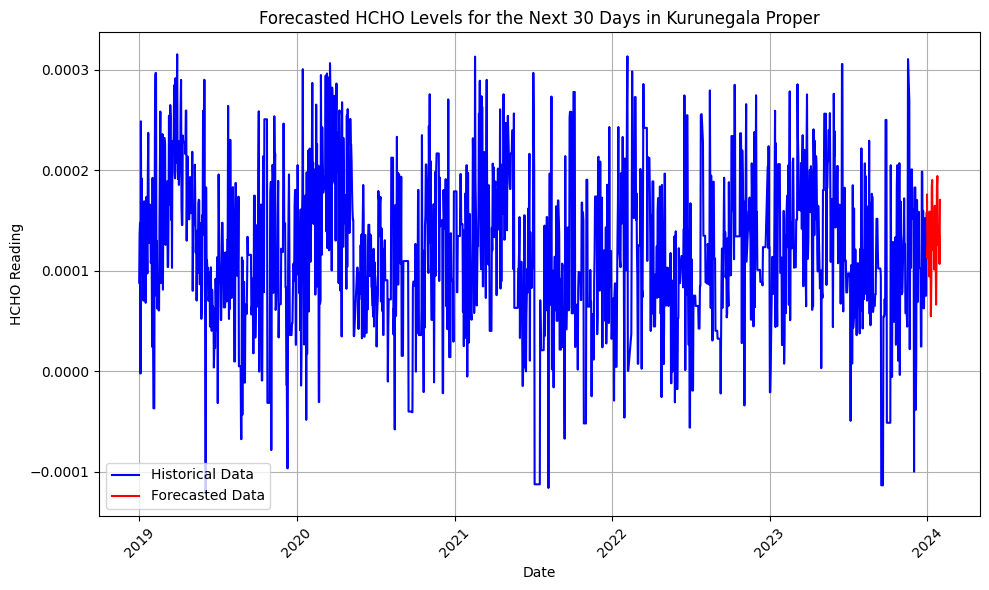

In [110]:
# Plot historical data
plt.figure(figsize=(10, 6))
plt.plot(kurunegala_data.index, kurunegala_data['HCHO Reading'], label='Historical Data', color='blue')

# Plot forecasted values for the next 10 days
forecast_dates = pd.date_range(start=kurunegala_data.index[-1], periods=31)
plt.plot(forecast_dates, forecast_30days, label='Forecasted Data', color='red')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('Forecasted HCHO Levels for the Next 30 Days in Kurunegala Proper')
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()


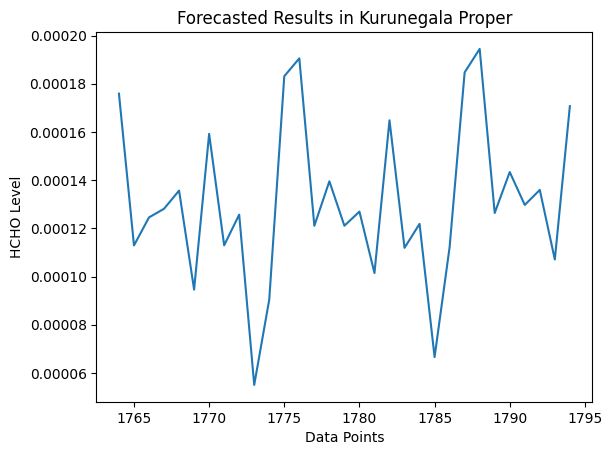

In [111]:
# Forecasted Results
plt.title("Forecasted Results in Kurunegala Proper")
plt.xlabel('Data Points')
plt.ylabel('HCHO Level')
plt.plot(forecast_30days)

### Bibile, Monaragala

#### Splitting the Data

In [112]:
#Splitting the dataset into train and test sets
split_ratio = 0.8 

bibile_data = HCHO_data[HCHO_data['Location'] == 'Bibile, Monaragala']
train_size = int(len(bibile_data) * split_ratio)
train_data_bibile, test_data_bibile = bibile_data[0:train_size], kurunegala_data[train_size:]

print("Full Data Size:-", bibile_data.shape)
print("Train Data Size :-", train_data_bibile.shape)
print("Test Data Size :-", test_data_bibile.shape)

Full Data Size:- (1747, 3)
Train Data Size :- (1397, 3)
Test Data Size :- (367, 3)


#### Model Creation and Evaluation

In [113]:
# Fitting the SARIMA Model
# Fit SARIMA model to the training data
sarima_model = SARIMAX(train_data_bibile['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

# Generate forecasts for the test set
test_forecast = sarima_result.forecast(steps=len(test_data_bibile))

# Calculate evaluation metrics
mse = mean_squared_error(test_data_bibile['HCHO Reading'], test_forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_bibile['HCHO Reading'], test_forecast)

# Print evaluation metrics
print("\nEvaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")



Evaluation Metrics:
Mean Squared Error (MSE): 7.867919961705432e-07
Root Mean Squared Error (RMSE): 0.0008870129627973558
Mean Absolute Error (MAE): 0.0008013281610666605


#### Forecasting next 30 Days

In [114]:
# Generate forecasts for the next 10 days by fitting entire dataset for the model
sarima_model = SARIMAX(bibile_data['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

forecast_30days = sarima_result.forecast(steps=31)

# Print the forecasted values
print("\nForecasted HCHO levels for the next 30 days:")
print(forecast_30days)


Forecasted HCHO levels for the next 30 days:
1747    0.000016
1748    0.000062
1749    0.000079
1750    0.000116
1751    0.000123
1752    0.000085
1753    0.000052
1754    0.000050
1755    0.000049
1756    0.000043
1757    0.000004
1758    0.000014
1759   -0.000016
1760    0.000028
1761    0.000043
1762    0.000103
1763    0.000109
1764    0.000055
1765    0.000029
1766    0.000027
1767    0.000026
1768    0.000021
1769   -0.000010
1770   -0.000002
1771   -0.000029
1772    0.000016
1773    0.000031
1774    0.000087
1775    0.000093
1776    0.000042
1777    0.000014
Name: predicted_mean, dtype: float64


#### Plotting Results

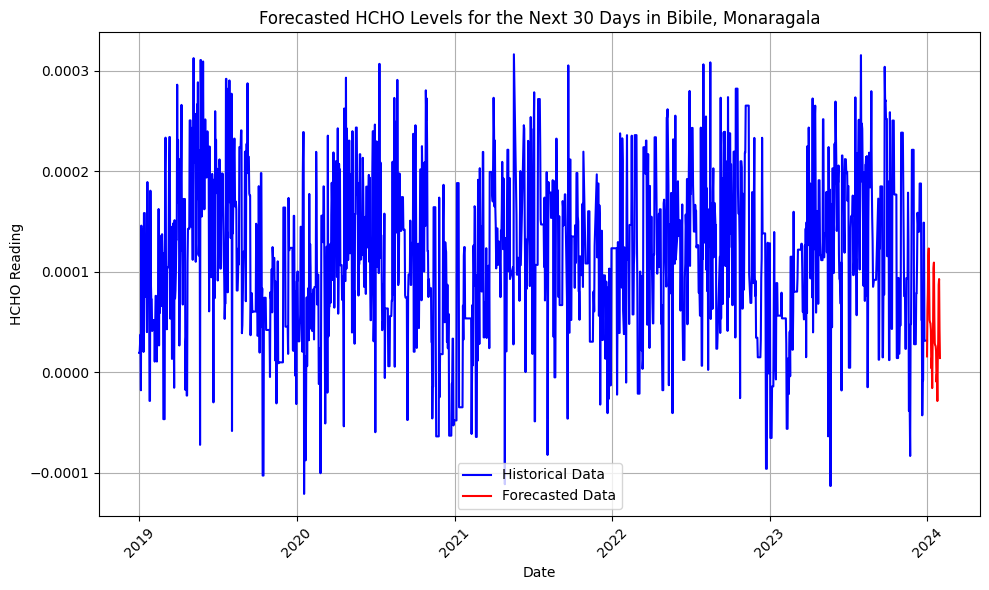

In [115]:
# Plot historical data
plt.figure(figsize=(10, 6))
plt.plot(bibile_data.index, bibile_data['HCHO Reading'], label='Historical Data', color='blue')

# Plot forecasted values for the next 10 days
forecast_dates = pd.date_range(start=bibile_data.index[-1], periods=31)
plt.plot(forecast_dates, forecast_30days, label='Forecasted Data', color='red')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('Forecasted HCHO Levels for the Next 30 Days in Bibile, Monaragala')
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()


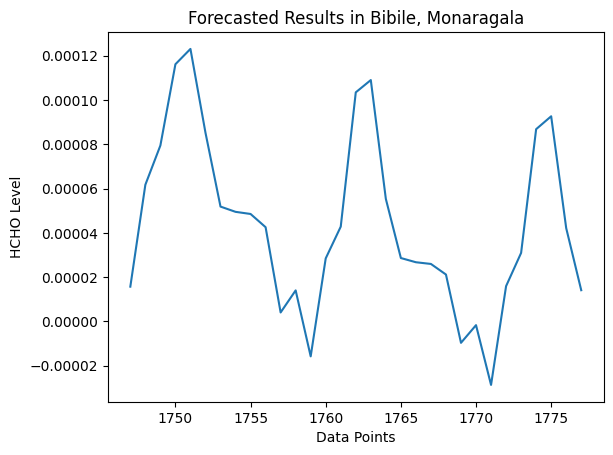

In [116]:
# Forecasted Results
plt.title("Forecasted Results in Bibile, Monaragala")
plt.xlabel('Data Points')
plt.ylabel('HCHO Level')
plt.plot(forecast_30days)

## Model Optimization

In [117]:
import itertools
import statsmodels.api as sm

# Define the p, d, q parameters for SARIMA
p = d = q = range(0, 2)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# Define seasonal p, d, q parameters
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

# Grid search over parameter combinations for city colombo
best_aic = float("inf")
best_params = None
best_seasonal_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(colombo_data['HCHO Reading'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
        except:
            continue

# Fit the SARIMA model with best parameters
best_model = sm.tsa.statespace.SARIMAX(colombo_data['HCHO Reading'],
                                       order=best_params,
                                       seasonal_order=best_seasonal_params,
                                       enforce_stationarity=False,
                                       enforce_invertibility=False)
best_results = best_model.fit()

# Print best model parameters and AIC
print('Best SARIMA model parameters:', best_params, best_seasonal_params)
print('Best AIC:', best_aic)

Best SARIMA model parameters: (1, 1, 1) (0, 0, 0, 12)
Best AIC: -28531.897418760993


Putting those parameters  to seasonal order make the Model to not function properly and generate NaN values.

## Cross Validation Folds over the Colombo Proper

In [124]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


### Colombo Proper

In [127]:
splits = 5  # Number of cross-validation splits

# Initialize TimeSeriesSplit
time_series_split = TimeSeriesSplit(n_splits=splits)

# Initialize lists to store evaluation metrics for each fold
mse_list = []
rmse_list = []
mae_list = []

# Perform cross-validation
for train_set, test_set in time_series_split.split(colombo_data):

    cv_train_data = colombo_data.iloc[train_set]['HCHO Reading']
    cv_test_data = colombo_data.iloc[test_set]['HCHO Reading']
    
    # Fit SARIMA model on training data for this fold
    sarima_model = SARIMAX(cv_train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_result = sarima_model.fit()
    
    # Generate forecasts for the test set of this fold
    test_forecast = sarima_result.forecast(steps=len(cv_test_data))
    
    # Calculate evaluation metrics for this fold
    mse = mean_squared_error(cv_test_data, test_forecast)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(cv_test_data, test_forecast)
    
    # Append evaluation metrics to lists
    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)

# Calculate mean evaluation metrics across all folds
mean_mse = np.mean(mse_list)
mean_rmse = np.mean(rmse_list)
mean_mae = np.mean(mae_list)

# Print mean evaluation metrics
print("\nMean Evaluation Metrics Across Cross-Validation Folds (Colombo Proper):")
print(f"Mean Squared Error (MSE): {mean_mse}")
print(f"Root Mean Squared Error (RMSE): {mean_rmse}")
print(f"Mean Absolute Error (MAE): {mean_mae}")



Mean Evaluation Metrics Across Cross-Validation Folds (Colombo Proper):
Mean Squared Error (MSE): 1.4327061126307565e-07
Root Mean Squared Error (RMSE): 0.00032217124906769084
Mean Absolute Error (MAE): 0.0002830270226080598


Concluding Machine Learning Chapter with cross-valiadtion folds shows that the created model's consistency and ability to performes in different types of data thorugh out the year.